**Target:**

    -- TO introduce accuracy we want the model to train on more difficult data. So we are introducing image augmentation in this step

**Results:**

    -- Parameters: 9,907
    -- Best Training Accuracy: 99.08
    -- Best Test Accuracy: 99.35 (for one epoch it went to 99.4 but it might be a fluke. so we weill not consider that)


**Analysis:**

    -- The accuracy has dropped a little (from 99.38 to 99.35) after introducing image augmentation.
    -- The training accuracy has gone down from 99.33 to 99.08. It is happening because, we are using doing image augmentation which means we are giving the model little more difficult data to train on 
    -- In some epochs, we can see that the training accuracy is increasing but the test accuracy is going up and down a little (which means the model is not able to find minima). 

#**Import libraries**

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#**Data Transformations (without normalization)** 

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor()
                                       ])


# **Dataset and Creating Train/Test Split (without normalization)**

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Dataloader Arguments & Test/Train Dataloaders (without normalization)**


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**Data Transformations (with normalization)**

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])


# **Dataset and Creating Train/Test Split (with normalization)**

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# **Dataloader Arguments & Test/Train Dataloaders (with normalization)**


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**plot some images to see which image augmentation to use (with normalization)**
We will plot some images to see which image augmentation technique we can use

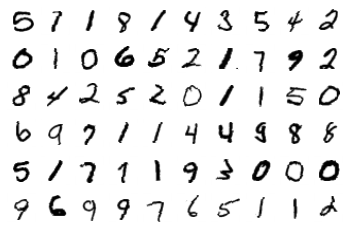

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

**Model**

In [ ]:
dropout_value = 0.05
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    #input block
    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 1, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  1+ (3-1)*1 = 3, C_out = 28
    
    #conv block 1
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 3, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  3+ (3-1)*1 = 5, , C_out = 28
    
    #conv block 2
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 5, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  5+ (3-1)*1 = 7, , C_out = 28
    
    #transition block1
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 7, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  7+ (3-1)*1 = 9, , C_out = 28

    self.pool1 = nn.MaxPool2d(2, 2) #R_in = 9, C_in = 28, K = 2, P = 0, S = 2, J_in = 1, J_out = 2, R_out = R_in + (K-1)*J_in =  9+ (2-1)*1 = 9, , C_out = 14

    #conv block 3
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels = 12, out_channels = 15, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(15),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 9, C_in = 14, K = 3, P = 1, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  9+ (3-1)*2 = 13, , C_out = 14
    
    #conv block 4
    self.convblock6 = nn.Sequential(nn.Conv2d(in_channels = 15, out_channels = 12, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 13, C_in = 14, K = 3, P = 1, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  13+ (3-1)*2 = 17, , C_out = 14
    #gap layer 
    self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)) #R_in = 17, C_in = 14, K = 4, P = 1, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  17+ (4-1)*2 = 23, , C_out = 14

    #output block
    self.convblock7 = nn.Sequential(nn.Conv2d(in_channels = 12, out_channels = 10, kernel_size = 3, padding = 0)) #R_in = 23, C_in = 14, K = 3, P = 0, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  23+ (3-1)*2 = 27, , C_out = 12

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.pool1(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.gap(x)
    x = self.convblock7(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

**Model parameters**

In [ ]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size = (1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
           Dropout-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,740
       BatchNorm2d-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
           Dropout-8           [-1, 12, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           1,744
      BatchNorm2d-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
          Dropout-12           [-1, 16, 28, 28]               0
    

**Training and Testing**

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08067099750041962 Batch_id=468 Accuracy=90.13: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0788, Accuracy: 9799/10000 (97.99%)

EPOCH: 1


Loss=0.07394429296255112 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0642, Accuracy: 9821/10000 (98.21%)

EPOCH: 2


Loss=0.0510823130607605 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0448, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.04546071216464043 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]



Test set: Average loss: 0.0377, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.09288108348846436 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0357, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.15499983727931976 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.052291665226221085 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]



Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.011208325624465942 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0302, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.01105866115540266 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.029755255207419395 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]



Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.018088825047016144 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.06271881610155106 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.015503124333918095 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.02440854348242283 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.039988454431295395 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]



Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)



In [ ]:
train_losses = [i.item() for i in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

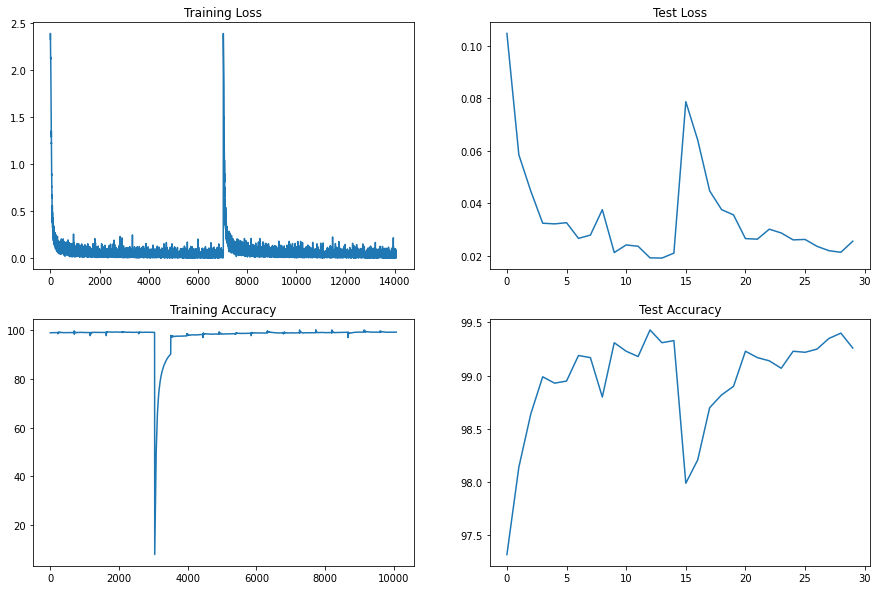

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")